## BUILDING A GAN USING CCNs

GANs allow generation of data by learning a distribution which mirrors that of a specific data input. Once the distribution is learned, data can be genereated. The generated data is similar but distinct from the original with the same statistics. There are two networks that make up a GAN: 

1. Generator (G) - produces fake data and maximizes on the probability of the discriminator making mistakes

2. Discriminator (D) - inspects the fake data and determines if it is real or fake 

The following architecture was builting using guidance from: 

https://www.youtube.com/watch?v=_pIMdDWK5sc

https://pytorch-lightning.readthedocs.io/en/stable/notebooks/lightning_examples/basic-gan.html

https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html

In [2]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Dataset
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import numpy as np
#from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

### Setting Parameters

In [3]:
random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

### The DataModule  

Includes the 5 steps in processding data with PyTorch:

1. Downloading the data
2. Cleaning the data
3. Loading the data into a dataset
4. Applying transformations 
5. Wrapping the data in a dataloader

Data cleaning and preparation is usually scattered across files DataModules make resharing and reusing the splits and transformations across projects possible

In [4]:
def sipakmed_prep():
    root = "../../Python Scripts/Datasets/CervicalCancer/Sipakmed/"

    all_img = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            curr_img = os.path.join(path,name)
            all_img.append(curr_img)

    sipakmed_df = pd.DataFrame()
    sipakmed_df['LocalPath'] = all_img
    sipakmed_df['ID'] = sipakmed_df['LocalPath'].apply(lambda x: str(x.split("\\")[-1]))
    sipakmed_df['Slide'] = sipakmed_df['LocalPath'].apply(lambda x: 'False' if (str(x.split("\\")[1])) == 'CROPPED' else 'True')
    sipakmed_df['Specific_Status'] = sipakmed_df['LocalPath'].apply(lambda x: str((x.split("im_")[1]).split("\\")[0]))
    sipakmed_df['Status'] = sipakmed_df['Specific_Status'].apply(lambda x: 'Benign' if x == 'Metaplastic' else
    ('Normal' if x == 'Superficial-Intermediate' or x == 'Parabasal' else 'Abnormal'))

    sp_class = {'Metaplastic':4, 'Superficial-Intermediate':0, 'Parabasal':1, 'Koilocytotic':2, 'Dyskeratotic':3}
    sipakmed_df['Specific_Class'] = sipakmed_df['Specific_Status'].map(sp_class)
    gen_class = {'Benign':0, 'Normal':1, 'Abnormal':2}
    sipakmed_df['Class'] = sipakmed_df['Status'].map(gen_class)

    sipakmed_df = sipakmed_df.loc[sipakmed_df['ID'].str.contains('bmp')].reset_index(drop=True)
    
    #Uploads the created file for future use. Recommended to not use.
    #sipakmed_df.to_csv(root + '/results.csv')
    return sipakmed_df

def herlev_prep():
    root = '../../Python Scripts/Datasets/CervicalCancer/Herlev/smear2005/results.csv'
    img_folder = '../../Python Scripts/Datasets/CervicalCancer/Herlev/smear2005/Images/'

    herlev_df=pd.read_csv(root)
    herlev_df = herlev_df.rename(columns={'Class':'Specific_Class'})

    spec_class = {1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6}
    gen_class = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2}
    
    herlev_df['Class'] = herlev_df['Specific_Class'].map(gen_class)
    herlev_df['Specific_Class'] = herlev_df['Specific_Class'].map(spec_class)
    herlev_df['LocalPath'] = herlev_df['ID'].apply(lambda x: str(img_folder + x))
    return herlev_df

def concat_data(batch_size=128, img_size=32):
    # Load the dataframes
    sipakmed_df = sipakmed_prep()
    herlev_df = herlev_prep()

    # Final adjustments to make sure they're attributes match
    sipakmed_df = sipakmed_df.loc[sipakmed_df['Slide'] == 'False']
    herlev_df = herlev_df.loc[:,['LocalPath', 'Class']]
    sipakmed_df = sipakmed_df.loc[:,['LocalPath', 'Class']]
    
    concat_df = pd.concat([sipakmed_df,herlev_df], ignore_index=True)
    
    '''
    concat_df = pd.DataFrame()
    concat_df['LocalPath'] = sipakmed_df['LocalPath']
    concat_df['Class'] = sipakmed_df['Specific_Class']
    concat_df = pd.DataFrame()
    concat_df['LocalPath'] = herlev_df['LocalPath']
    concat_df['Class'] = herlev_df['Specific_Class']
    '''


    # Split them into training, validation, and testing sets
    train_set,val_test_set = train_test_split(concat_df, random_state=1, test_size=0.30)
    val_set,test_set = train_test_split(val_test_set, random_state=1, test_size=0.50)
    
    # Set it up to alter random training images for better results
    train_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((img_size, img_size)),
                    #transforms.RandomHorizontalFlip(p=0.75),
                    #transforms.RandomRotation(degrees=60),
                    #transforms.RandomApply(transforms=[transforms.ColorJitter(brightness=.2, hue=.2)], p=0.75),
                    transforms.ToTensor()])

    test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((img_size, img_size)),
                    transforms.ToTensor()])

    train_dataset = DatasetSample(train_set, train_transform)
    val_dataset = DatasetSample(val_set, test_transform)
    test_dataset = DatasetSample(test_set, test_transform)
    
    Dtr = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=torch.Generator().manual_seed(17)
    )
    
    Dva = DataLoader(
        val_dataset, 
        batch_size=batch_size,
        shuffle=False
    )

    Dte = DataLoader(
        test_dataset, 
        batch_size=batch_size,
        shuffle=False
    )

    return(Dtr, Dva, Dte)

In [5]:
class DatasetSample(Dataset):
    def __init__(self, df, transform):
        # Initialization
        self.transform = transform
        
        self.image_names = df['LocalPath']
        self.img_class = np.array(df['Class'])

    def __len__(self):
        # Denotes the total number of samples
        return len(self.image_names)
    
    def __getitem__(self, index):
        # Retrieves the data
        image=cv2.imread(self.image_names.iloc[index])
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        image = self.transform(image)
        label = self.img_class[index]

        x, y = image, label
        
        # Enable to output as single variable instead
        #sample = {'image': image,'labels':label}

        return x, y

In [6]:
class CellDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )#Converts images to a tensor and normalizes based on mean - 0.1307 and std - 0.3081 of the MNIST images

    def prepare_data(self):
        self.train_set_train, self.train_set_val, self.train_set_test = concat_data()

    def setup(self, stage=None):
        '''
        # Assign or further split the training data into train/val datasets
        if stage == "fit" or stage is None:
            train_set_full = train_set(self.data_dir, train=True, transform=self.transform)
            self.train_set_train, self.train_set_val = random_split(train_set_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.train_set_test = train_set(self.data_dir, train=False, transform=self.transform)
        '''
    #Create dataloaders for the training, validation, and testing datasets
    def train_dataloader(self):
        return self.train_set_train

    def val_dataloader(self):
        return self.train_set_val

    def test_dataloader(self):
        return self.train_set_test

### Creating the Generator

In [7]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):#latent_dim is a scalar upsampled to ouput value that has similar dimensions as original image
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  #normal convolution restores to this shape -> [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #reshape 256 
        
        # Upsample (transposed conv) to reshape data to 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Normal Convolution to restore data to 28x28 (1 feature map)
        return self.conv(x)

### Creating the Discriminator 

In [17]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN - Uses 2 CNN layers
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):#Applies all layers
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)#Reshape the data to feed into the connected layers
        x = F.relu(self.fc1(x))#Application of first fully connected layer - linear
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)#Ensures output is between 0 and 1

### Join Networks Together to Create One Class

In [9]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002): #lr-learning rate
        super().__init__()
        self.save_hyperparameters()#stores hyperparameters and makes it accessible 
        
        #Create the two networks
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        
        #Create random noise to test the images
        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        
    def forward(self,z): #z - input tensor forward pass in a GAN is the generator
        return self.generator(z)
    
    def adversarial_loss(self,y_hat,y):
        return F.binary_cross_entropy(y_hat,y)
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_imgs, _ = batch
        
        #Sample Noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(real_imgs)
        
        #Train Generator: Max log(D(G(z))) where z is the random noise
        if optimizer_idx == 0:
            fake_imgs = self(z)
            y_hat = self.discriminator(fake_imgs)
            #Real 
            y = torch.ones(real_imgs.size(0),1)
            y = y.type_as(real_imgs)
            
            g_loss = self.adversarial_loss(y_hat, y)
            
            log_dict = {"g_loss": g_loss}
            return {"loss": g_loss, "progress_bar": log_dict, "log": log_dict}
        
        #Train the Discriminator Max log(D(x)) + log(1 - D(G(z)))
        if optimizer_idx == 1:
        
            #Check how well it can label the generated images as real 
            y_hat_real = self.discriminator(real_imgs)
            y_real = torch.ones(real_imgs.size(0),1)
            y_real = y_real.type_as(real_imgs)
            
            #Calculate the real loss
            real_loss = self.adversarial_loss(y_hat_real, y_real)
            
            #Check how well it can label the generated images as fake
            y_hat_fake = self.discriminator(self(z).detach())#.detach creates a new tensor that's separated from the computational graph
            y_fake = torch.zeros(real_imgs.size(0),1)
            y_fake = y_fake.type_as(real_imgs)
            
            #Calculate the fake loss
            fake_loss = self.adversarial_loss(y_hat_fake, y_fake)
            
            #Calculate the total loss
            d_loss = (real_loss + fake_loss)/2
            log_dict = {"d_loss": d_loss}
            return {"loss": d_loss, "progress_bar": log_dict, "log": log_dict}
    
    def configure_optimizers(self):
        lr = self.hparams.lr
        #Create two optimizers - one for each network 
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d], []
    
    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        
        print('epoch', self.current_epoch)
        fig = plt.figure()
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap='gray_r', interpolation='none')
            plt.title("GAN Generated Data")
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()
        
    def on_epoch_end(self):
        self.plot_imgs()
          

### Testing the GAN 

In [18]:
dm = CellDataModule()
model = GAN()

epoch 0


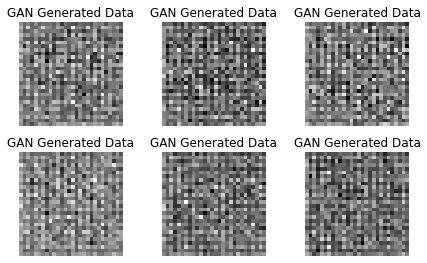

In [19]:
model.plot_imgs()

In [20]:
train = pl.Trainer(max_epochs=20, gpus=AVAIL_GPUS)
train.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 358 K 
1 | discriminator | Discriminator | 21.4 K
------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/28 [00:00<?, ?it/s] 

RuntimeError: Given groups=1, weight of size [10, 1, 5, 5], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead